# Diffraction Ring Based Detector Geometry Calibration

This notebook serves demonstrates how to use ipython based widgets to create a starting geometry from Power Based ring diffraction pattern.

In [1]:
import os
import sys

# This is important for interactive plots
%matplotlib notebook
from matplotlib import pyplot as plt
import matplotlib.patches as patches

parent = os.path.dirname(os.path.abspath(os.path.dirname('.')))
sys.path.insert(0, parent)
import numpy as np

from extra_data import RunDirectory, stack_detector_data
from geoAssembler import CalibrateNb as Calibrate

# Geometry using AGIPD Data


## Get a run dataset with ring pattern

The XMPL (example) instrument has some runs with interesting data. Run 5 contains data with diffraction patterns from Lithium Titanate. First open this run with EXtra-data and read the data


In [2]:
run_dir = '/gpfs/exfel/exp/XMPL/201750/p700000/proc/r0005'
run = RunDirectory(run_dir)
run.info()

# of trains:    156
Duration:       0:00:15.6
First train ID: 198425241
Last train ID:  198425396

16 detector modules (SPB_DET_AGIPD1M-1)
  e.g. module SPB_DET_AGIPD1M-1 0 : 512 x 128 pixels
  SPB_DET_AGIPD1M-1/DET/0CH0:xtdf
  176 frames per train, up to 27456 frames total

0 instrument sources (excluding detectors):

0 control sources:



## Read the train data

In [3]:
tId, train_data = run.select('*/DET/*').train_from_index(3)
tId

198425244

Use the ```stack_detector_data``` to create a big with all pulses for the selected train data. 

In [4]:
train_array = stack_detector_data(train_data, 'image.data')
train_array.shape

(176, 16, 512, 128)

Let's apply the ```sum``` function over a train rather than selecting single pulses. This can help to get a clearer signal, if necessary.

In [5]:
data_array = np.sum(np.clip(train_array, 0, 2000), axis=0)
data_array.shape

(16, 512, 128)

### Start the geometry calibration without prior geometry knowledge
First lets assume that we have no prior knowledge about the detector geometry. We naively just assume that all modules equally spaced with 29px distance to each other.

<IPython.core.display.Javascript object>


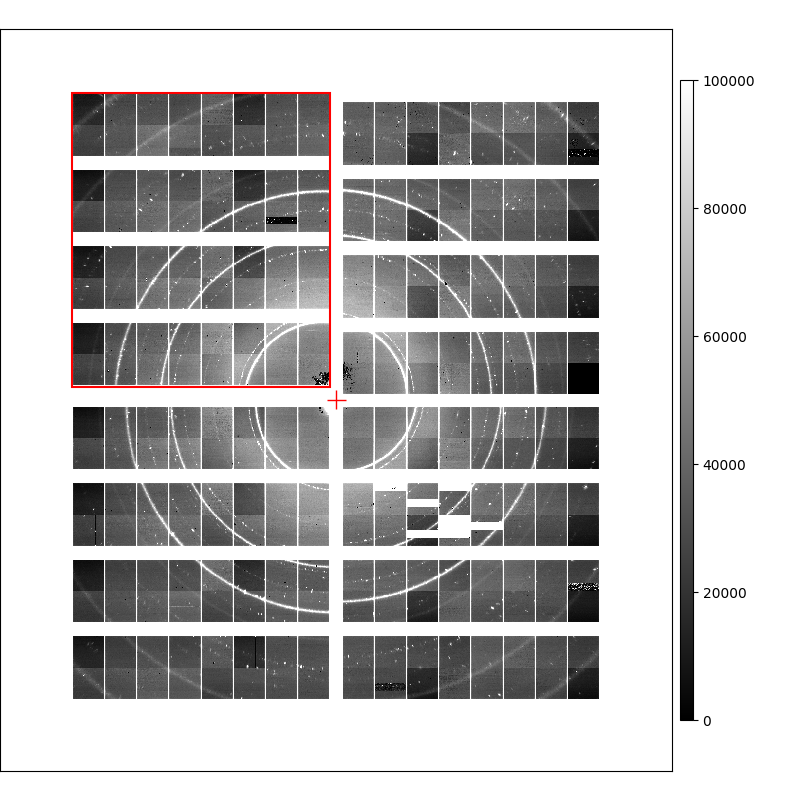

In [6]:
Calib =  Calibrate(data_array, geometry=None, vmin=0, vmax=1e5, figsize=(8,8), det='AGIPD')

Helper circles that guide the quadrant movement can be added by pushing the *Add circle* button. There can be multiple at a time. If there are different circles present, individual circles can be selected using the *Sel.* drop down menu. The radius can be adjusted with help of the *Radius* menu.

The quadrants can be moved by selecting a Quadrant from the *Quadrant* menu. The selected quadrant can be moved horizontally and vertically via the *Horizontal* and *Vertical* spin boxes.

The centre of the geometry can be retrieved with the ```centre``` attribute:

In [7]:
Calib.centre

array([614, 540])

Finally the geometry can be saved by calling ```C.geom.write_crystfel_geom```. This method gets the output filename, and some metadata which tools like CrystFEL expect in geometry files (check these parameters with instrument scientists):

In [8]:
Calib.geom.write_crystfel_geom(
    'testing.geom',
    adu_per_ev=0.0075,
    clen=0.119,  # Detector distance in m
    photon_energy=10235 , # Photon energy in eV
)

The new geometry file could also be loaded for another round of refinement:

<IPython.core.display.Javascript object>


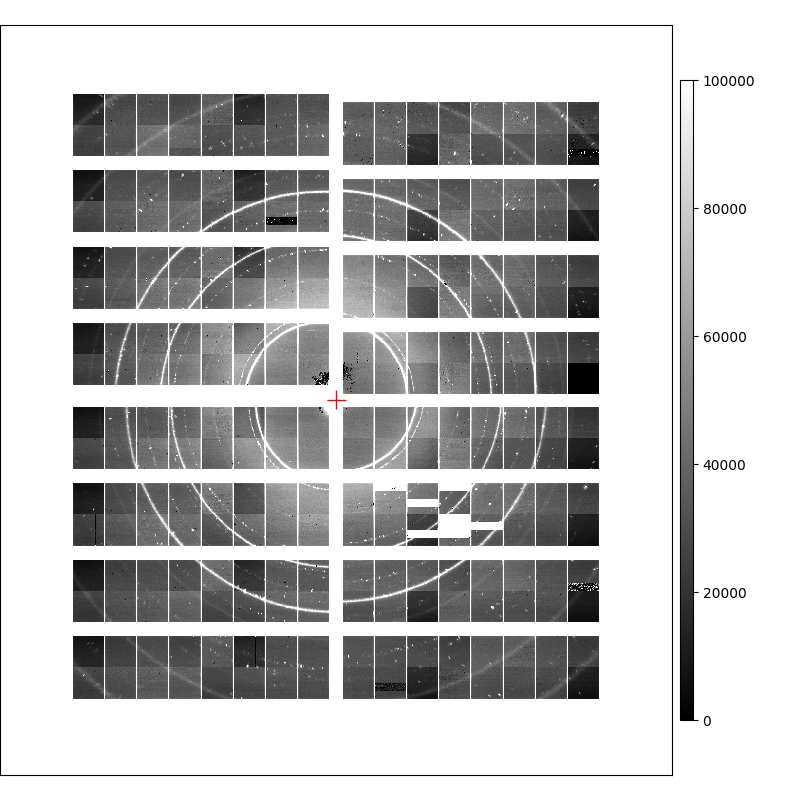

In [9]:
C_new =  Calibrate(data_array, geometry=Calib.geom, vmin=0, vmax=1e5, figsize=(8,8), det='AGIPD')

# Geometry using LPD Data

Here we'll work with HDF5 geometry information from the EuXFEL detector group. This format requires quadrant positions passed in separately. 

## Get a run dataset with ring pattern

The XMPL (example) instrument has some runs with interesting data. Run 7 contains LPD data with diffraction patterns. First open this run with EXtra-data and read the data:

In [10]:
run_dir = '/gpfs/exfel/exp/XMPL/201750/p700000/proc/r0007'
run = RunDirectory(run_dir)
run.info()

# of trains:    507
Duration:       0:00:50.7
First train ID: 1487289920
Last train ID:  1487290426

13 detector modules (FXE_DET_LPD1M-1)
  e.g. module FXE_DET_LPD1M-1 0 : 256 x 256 pixels
  FXE_DET_LPD1M-1/DET/0CH0:xtdf
  30 frames per train, up to 15210 frames total

0 instrument sources (excluding detectors):

0 control sources:



## Read the train data

In [11]:
tId, train_data = run.select('*/DET/*').train_from_index(3)
tId

1487289923

Use the ```stack_detector_data``` to create a big with all pulses for the selected train data. 

In [12]:
train_array = stack_detector_data(train_data, 'image.data')
train_array.shape

(30, 16, 256, 256)

Let's apply the ```sum``` function over a train rather than selecting single pulses. This can help to get a clearer signal, if necessary.

In [13]:
data_array = np.sum(np.clip(train_array, 0, 2000), axis=0)
data_array.shape

(16, 256, 256)

### Start the geometry calibration from an existing EuXFEL geometry file

From a users perspective the EuXFEL format is a little more complicated. Quadrant positions and a geometry file describing the positions of the tiles within the quadrants is needed.

The geometry file we're using here is the same one as in the EXtra-geom examples.

In [14]:
from extra_geom import LPD_1MGeometry

geom = LPD_1MGeometry.from_h5_file_and_quad_positions(
    'lpd_mar_18_axesfixed.h5', [
        (11.4, 299),
        (-11.5, 8),
        (254.5, -16),
        (278.5, 275)
    ]
)

<IPython.core.display.Javascript object>


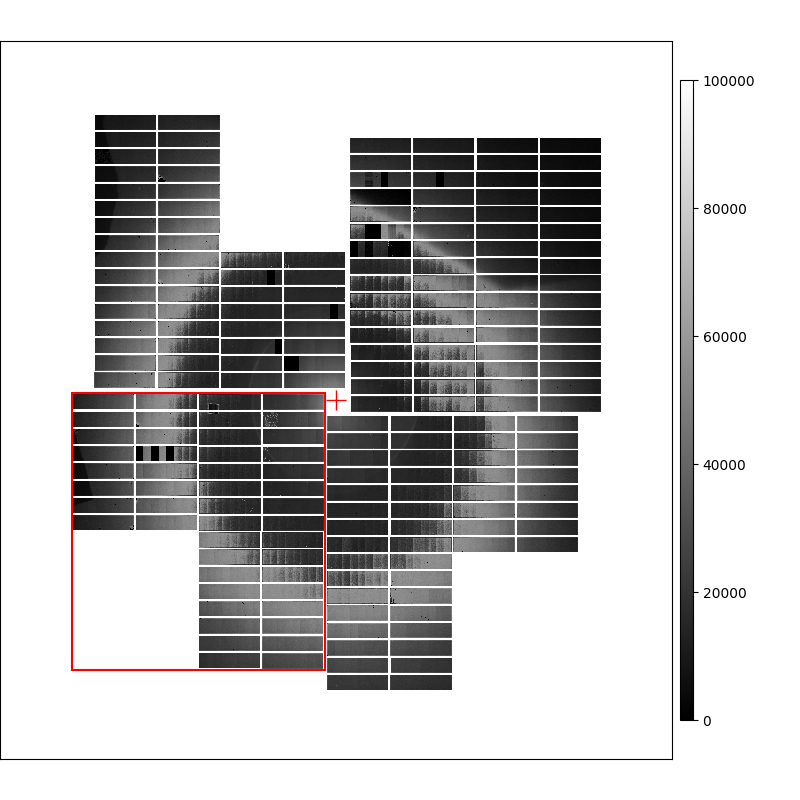

In [15]:
Calib =  Calibrate(data_array, geometry=geom, vmin=0, vmax=100000, figsize=(8,8), det='LPD')

### Read the quadrant positions

geoAssembler only modifies the quadrant positions which are used along with the EuXFEL HDF5 geometry file.
You can retrieve the modified positions from the `Calib.geom` object:

In [16]:
Calib.geom.quad_pos

,X,Y
q1,11.4,299.0
q2,-11.5,6.5
q3,254.5,-16.0
q4,278.5,275.0


The modified geometry can also be passed in for another round of refinement:

<IPython.core.display.Javascript object>


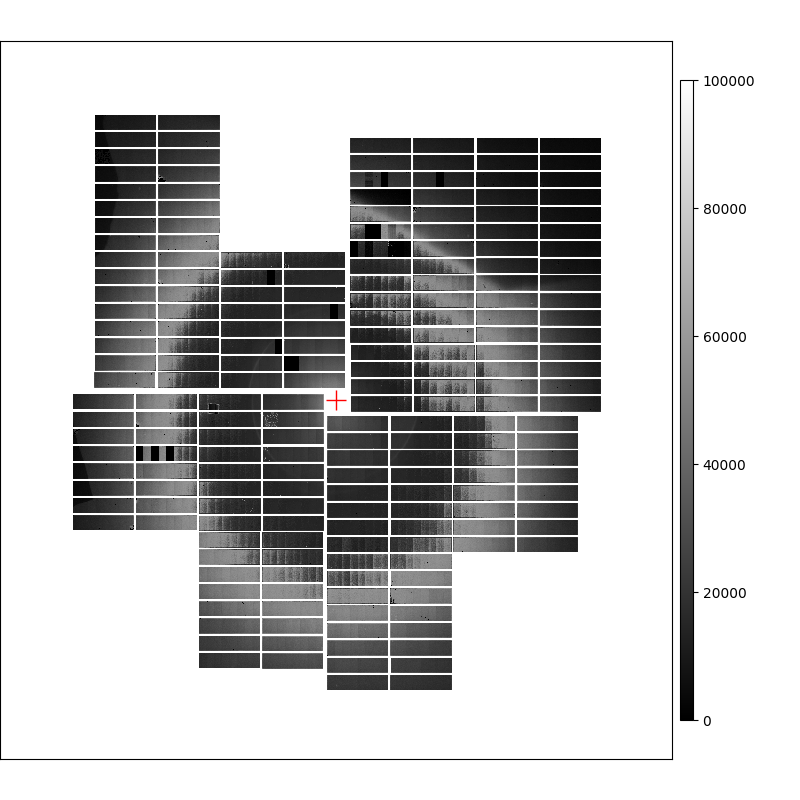

In [17]:
Calib_New =  Calibrate(data_array, geometry=Calib.geom, vmin=0, vmax=100000, figsize=(8,8), det='LPD')